# **Engineering a Kerr-based Deterministic Cubic Phase Gate via Gaussian Operations in Strawberry Fields**

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
def plot_wigner(state, title = "Wigner Function of State"):
    fig = plt.figure()
    x = np.linspace(-10, 10, 100)
    p = np.linspace(-10, 10, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()

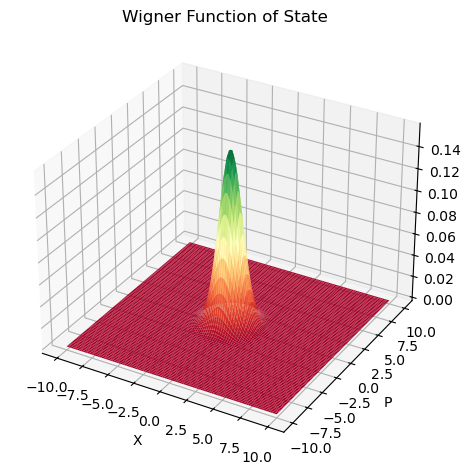

In [25]:
''' define the parameters '''
lam = 10 # in-phase quadrature power gain = lab^2
alpha = 1 + 7j

# convert alpha to polar coordinates
r = np.abs(alpha)
phi = np.angle(alpha)


prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    Sgate(np.log(lam), 0) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    # inverse operations
    Dgate(-r, phi) | q[0]
    Sgate(-np.log(lam), 0) | q[0]
    
    
eng = sf.Engine('gaussian') 
state = eng.run(prog).state
plot_wigner(state)